In [26]:
import json 
import numpy as np
import math
import sys
import random 
class Field:
    def __init__(self, field):
        self.field = figures
        self.w_width = self.field['main_rectangle'][0][0]
        self.w_length = self.field['main_rectangle'][0][1]
        
    def __init(self, path):
        with open(path, "r") as f:
            self.field = json.loads(f.read())
        self.w_width = self.field['main_rectangle'][0][0]
        self.w_length = self.field['main_rectangle'][0][1]

In [28]:
class Robot(Field):
    def __init__(self, x = 1, y = 0.5, yaw = 0):
        self.x = x          # robot's x coordinate
        self.y = y          # robot's y coordinate
        self.yaw = yaw  # robot's orientation 
        self.forward_noise = 0.05   # noise of the forward movement
        self.turn_noise = 0.1      # noise of the turn
        self.sense_noise = 1   # noise of the sensing
        
        
    def set_coord(self, new_x, new_y, new_orientation):
        #if new_orientation < 0 or new_orientation >= 2 * pi:
        #   raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.yaw = float(new_orientation)
        
    def set_noise(self, new_forward_noise, new_turn_noise, new_sense_noise):
        self.forward_noise = float(new_forward_noise)
        self.turn_noise = float(new_turn_noise)
        self.sense_noise = float(new_sense_noise)  
    
    def sense(self, landmarks):
        z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 
                             + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            z.append(dist)
        return z
    
    
    def move(self, x, y, yaw):
        # turn, and add randomness to the turning command
        orientation = self.yaw + float(yaw) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * math.pi

        # move, and add randomness to the motion command
        x = self.x + x + random.gauss(0, self.forward_noise)
        y = self.y + y + random.gauss(0, self.forward_noise)
        
        #x = math.copysign(Field.w_width, x) if math.fabs(x) >= Field.w_width
        if math.fabs(x) >= field.w_width:
            x = math.copysign(field.w_width/2.0, x)
        if math.fabs(y) >= field.w_length:
            y = math.copysign(field.w_length/2.0, y)
            
        # set particle
        self.x = x
        self.y = y
        self.yaw = orientation
    
    def gaussian(self, x, sigma):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return math.exp(-(x ** 2) / 2*(sigma ** 2)) / math.sqrt(2.0 * math.pi * (sigma ** 2))
    
    def observation_score(self, observations, landmarks): #particle weight calculation
        prob = 1.0
        matrix_means_land = []
        for color_landmarks in landmarks:
            for landmark in landmarks[color_landmarks]:
                dists = []
                if observations[color_landmarks]:
                    for observation in observations[color_landmarks]:
                #calc posts coords in field for every mesurement
                        x_posts = self.x + observation[0]*math.sin(-self.yaw) + observation[1]*math.cos(-self.yaw)
                        y_posts = self.y + observation[0]*math.cos(-self.yaw) - observation[1]*math.sin(-self.yaw)
                        dist = math.sqrt((x_posts - landmark[0])**2 + (y_posts - landmark[1])**2)
                        dists.append(dist)
                prob *= self.gaussian(min(dists), self.sense_noise)
        return prob
    
    def update_coord(self, particles):
        x = 0.0
        y = 0.0 
        orientation = 0.0
        for particle in particles:
            x += particle[0].x * particle[1]
            y += particle[0].y * particle[1]
            orientation += particle[0].yaw * particle[1]
        self.x = x
        self.y = y
        self.yaw = orientation
    
    def return_coord(self):
        return self.x, self.y, self.orientation

In [166]:
class ParticleFilter():
    def __init__(self, myrobot, field, landmarks,
                 n = 200, forward_noise = 0.025, 
                 turn_noise = 0.1, sense_noise = 0.1, gauss_noise = 0.4):
        self.forward_noise = forward_noise
        self.turn_noise = turn_noise
        self.sense_noise = sense_noise
        self.gauss_noise = gauss_noise
        self.logs = open('logs/logs.txt','w')
        self.n = n  # number of particles
        self.count = 0
        self.myrobot = myrobot
        self.p = [] 
        self.yaw_noise = 0.05
        self.gen_particles() 
        self.landmarks = landmarks
        sys.stdout = self.logs
        
        
            
    def custom_reset(self):
        self.p=[]
        for i in range(self.n):
            x = Robot((random.random()-0.5)*field.w_width, (random.random()-0.5)*field.w_length, random.random()*math.pi*2)
            #x.set_noise(forward_noise, turn_noise, 0)
            self.p.append([x,0])
        self.myrobot.update_coord(self.p)
            
    def gen_particles(self):
        print('initial,step ', self.count, file=self.logs)
        print("position ", self.myrobot.x, ' ', 
              self.myrobot.y, ' ', self.myrobot.yaw, '|', file=self.logs)
        self.p = []
        for i in range(self.n):
            x_coord = self.myrobot.x + random.gauss(0, self.sense_noise)
            y_coord = self.myrobot.y + random.gauss(0, self.sense_noise)
            yaw = self.myrobot.yaw + random.gauss(0, self.yaw_noise)*math.pi
            yaw %= 2 * math.pi
            self.p.append([Robot(x_coord, y_coord, yaw), 0])
            print(x_coord, ' ', y_coord, ' ', yaw, file=self.logs)
        #print('|', file = self.logs)
        self.count += 1
            
    def move(self, x, y, yaw):
        self.myrobot.move(x, y, yaw)
        print('|moving,step ', self.count, file=self.logs)
        print("position ", self.myrobot.x, ' ', 
              self.myrobot.y, ' ', self.myrobot.yaw, '|', file=self.logs)
        # now we simulate a robot motion for each of
        # these particles
        for partic in self.p:
            partic[0].move(x, y, yaw)
            print(partic[0].x, ' ', 
              partic[0].y, ' ', partic[0].yaw, file=self.logs) 
        #print('|', file = self.logs)  
        self.count += 1
            
            
    def do_n_steps(self, n_steps):
        for i in range(n_steps):
            self.step()
            
    def gen_n_particles_robot(self, n):
        p = []
        for i in range(n):
            x_coord = self.myrobot.x + random.gauss(0, self.sense_noise*3)
            y_coord = self.myrobot.y + random.gauss(0, self.sense_noise*3)
            yaw = self.myrobot.yaw + random.gauss(0, self.yaw_noise*3)*math.pi
            yaw %= 2 * math.pi
            p.append([Robot(x_coord, y_coord, yaw), 0])
        return p
    def gen_n_particles(self, n):
        tmp = []
        for i in range(n):
            x = Robot((random.random()-0.5)*field.w_width, (random.random()-0.5)*field.w_length, random.random()*math.pi*2)
            #x.set_noise(forward_noise, turn_noise, 0)
            tmp.append([x,0])
        return tmp
        
    def resampling(self, observations):
        print('|resempling,step ', self.count, file=self.logs)
       
        p_tmp = []
        w = []
        S = 0
        for i in range(self.n):
            w.append(self.p[i][0].observation_score(observations, self.landmarks))
            S += (w[i])
        for i in range(self.n):
            w[i] = w[i]/S
            #S += w[i]
        index = int(random.random() * self.n)
        beta = 0.0
        mw = max(w)
        #print(mw)
        new_particles = {}
        for i in range(self.n):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % self.n
            if index in new_particles.keys():
                new_particles[index] += 1
            else:
                new_particles[index] = 1
            #p_tmp.append([self.p[index][0],w[index]])
        #print(p_tmp)
        for el in new_particles:
            p_tmp.append([self.p[el][0],w[el]*new_particles[el]])

        S = 0
        for i in range(len(p_tmp)):
            S += p_tmp[i][1]
        for i in range(len(p_tmp)):
            p_tmp[i][1] /= S
        self.myrobot.update_coord(p_tmp)
        print("position ", self.myrobot.x, ' ', 
              self.myrobot.y, ' ', self.myrobot.yaw, '|', file=self.logs)
        new_particles = self.gen_n_particles_robot(self.n - len(p_tmp))
        p_tmp.extend(new_particles)
        self.p = p_tmp
        for particle in p_tmp:
            print(particle[0].x, ' ', 
              particle[0].y, ' ', particle[0].yaw, file=self.logs) 
        #print('|', file = self.logs)
        self.count += 1





        

In [30]:
figures = {
    "circles": [
    [3, 4.5, 1]
    ], 
    "lines": [
     [[0, 9], [4.5, 4.5]] 
    ], 
    "points": [
        [0, 0]
    ], 
    "main_rectangle": [
        [6, 9]
    ], 
    "rectangles": [
        [[2, 0], 2, 1],[[2,8],2,1]
    ]
}

In [31]:
path = "untitled.json"
field = Field(path)

In [32]:
field.field

{'circles': [[3, 4.5, 1]],
 'lines': [[[0, 9], [4.5, 4.5]]],
 'points': [[0, 0]],
 'main_rectangle': [[6, 9]],
 'rectangles': [[[2, 0], 2, 1], [[2, 8], 2, 1]]}

In [43]:
import matplotlib.pylab as plt
def visualization(robot, step, p, pr, factor = 7 ):
    
    plt.figure("Robot in the world",figsize=(field.w_width, field.w_length))
    plt.title('Particle filter, step ' + str(step))
 
    # draw coordinate grid for plotting
    grid = [-field.w_width/2.0, field.w_width/2.0, -field.w_length/2.0, field.w_length/2.0]
    ax = plt.axis(grid)
    
    for el in field.field:
        if el == 'circles':
            for circle in field.field['circles']:
                plot_circle = plt.Circle((circle[0], circle[1]), circle[2],linewidth=2, fill=False, edgecolor='#330000')
                plt.gca().add_patch(plot_circle)
        if el == 'lines' :     
            for line in field.field['lines']:
                plot_line = plt.Line2D(line[0], line[1], linewidth=2, linestyle="-", color='#330000')
                plt.gca().add_line(plot_line)
        if el == 'rectangles' :     
            for rectangle in field.field['rectangles']:
                rect = plt.Rectangle(rectangle[0], rectangle[1], rectangle[2], linewidth=2, linestyle="-", fill = False, edgecolor='#330000')
                plt.gca().add_patch(rect)
    '''
    # draw particles
    for ind in range(len(p)):
 
        # particle
        circle = plt.Circle((p[ind][0].x, p[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#994c00', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(p[ind][0].x, p[ind][0].y, 2*math.cos(p[ind][0].yaw)/factor, 2*math.sin(p[ind][0].yaw)/factor, width=1/factor, alpha=1., facecolor='#994c00', edgecolor='#994c00')
        plt.gca().add_patch(arrow)
    '''
    # draw resampled particles
    for ind in range(len(pr)):
 
        # particle
        circle = plt.Circle((pr[ind][0].x, pr[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#cc0000', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(pr[ind][0].x, pr[ind][0].y, 2*math.cos(pr[ind][0].yaw)/factor, math.sin(pr[ind][0].yaw)/factor,width=1/factor, alpha=1., facecolor='#006600', edgecolor='#006600')
        plt.gca().add_patch(arrow)
 

    # robot's location
    circle = plt.Circle((robot.x, robot.y), 1./factor/2, facecolor='#FF66E9', edgecolor='#FF66E9')
    plt.gca().add_patch(circle)
 
    # robot's orientation
    arrow = plt.Arrow(robot.x, robot.y, math.cos(robot.yaw)/factor, math.sin(robot.yaw)/factor, width=1/factor, alpha=0.5, facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow)


    #fixed landmarks of known locations2
   
    for lm in landmarks:
        for lms in landmarks[lm]:
            circle = plt.Circle(((lms[0], lms[1])), 
                                1./factor/2, facecolor = '#060C73', edgecolor='#060C73')
            plt.gca().add_patch(circle)
    
 
    plt.savefig("figure_" + str(step) + ".png")
    #plt.close()

In [ ]:
def initPF():
    

In [56]:
landmarks = [[-1, 4.5],[1,4.5]]

In [209]:
robot = Robot()
robot.set_coord(0, 0, math.pi/2)
               

In [210]:
pf = ParticleFilter(robot, field, landmarks, sense_noise = 0.5, n = 200)

In [211]:
p = pf.p
observations = {"blue_posts": [[-1,4.5],[1,4.5]], 
              "yellow_posts":[[-1,-4.5],[1,-4.5]]}

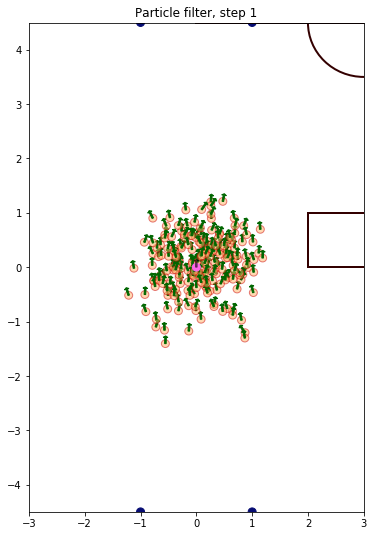

In [101]:
visualization(robot, 1, p, pf.p, factor = 7)

In [214]:
#pf.custom_reset()
pf.resampling(observations)
#visualization(robot, 1, [], pf.p, factor = 7)
#m = max(pf.p, key=lambda tup: tup[1])[0]
#score = max(pf.p, key=lambda tup: tup[1])[1]
#print(m.x,m.y,m.orientation)

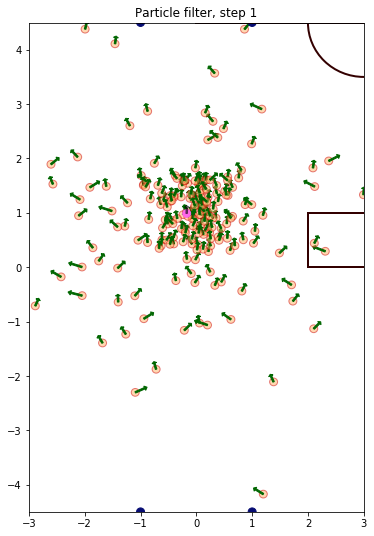

In [213]:
observations = {"blue_posts": [[-1,3.5],[1,3.5]], 
              "yellow_posts":[[-1,-4.5],[1,-4.5]]}
pf.move(0.0,1.0,0)
visualization(robot, 1, p, pf.p, factor = 7)

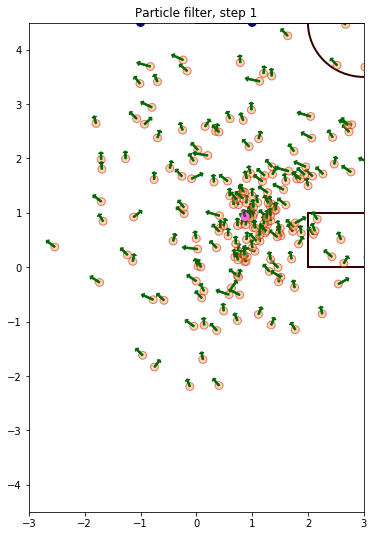

In [2209]:
pf.resampling(measurment, landmarks)
visualization(robot, 1, p, pf.p, factor = 7)

In [34]:
z = [[3.162868755835978, 2.677945044588987],
 [1.665373697724714, 2.1587989303424644]]

In [1948]:
measurement = [[-1,4.5],[1,4.5]]

In [1957]:
x = 1.0 
y = 1.0
orientation = math.pi/2 + 0.5

In [1958]:
measurement_prob(measurement)

1.0354410307910031
1.5811927555563356
prob  2.0009582920794168e-10
x =  1.0 y =  1.0 yaw =  118.64788975654116
govno x =  -2.034997485609286
govno y =  4.469695989902474
[[-1, 4.5], [1, 4.5]]


2.0009582920794168e-10

In [691]:
def measurement_prob(measurement): #particle weight calculation
        prob = 1.0
        for i in range(len(landmarks)):
            dists = []
            for measurment_ in measurement:
                dist = math.sqrt((x + measurment_[0]*math.sin(-orientation) 
                             + measurment_[1]*math.cos(-orientation) - landmarks[i][0]) ** 2 
                             + (y + measurment_[0]*math.cos(-orientation) 
                                  - measurment_[1]*math.sin(-orientation) - landmarks[i][1])** 2 )
                dists.append(dist)
            #print(self.gaussian(dist, self.sense_noise, measurement[i]))
            #prob *= self.gaussian(dist, self.sense_noise, math.sqrt(measurement[i][0]**2+measurement[i][1]**2)) 
            prob *= gaussian(min(dists), 0.4) 
            print(min(dists))
        print("prob ", prob)
        print("x = ", x, "y = ", y, "yaw = ", orientation/math.pi * 180)
        print("govno x = ", x + measurment_[0]*math.sin(-orientation) 
                             + measurment_[1]*math.cos(-orientation) )
        print("govno y = ",  y +  measurment_[0]*math.cos(-orientation) 
                                  - measurment_[1]*math.sin(-orientation))
        print(landmarks)
        print("====="*10)
        return prob
def gaussian(x, sigma):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
    return math.exp(-(x ** 2) / (sigma ** 2)) / math.sqrt(2.0 * math.pi * (sigma ** 2))

In [59]:
observations = {"blue_posts": [[-1,4.5],[1,4.5]], 
              "yellow_posts":[[-1,-4.5],[1,-4.5]]}

In [15]:
rem = []

In [16]:
if rem:
    print("empty")

In [34]:
landmarks = {"blue_posts": [
    [-1.0, 4.5], [1.0, 4.5]
    ],
    "yellow_posts":[
    [-1.0, -4.5], [1.0, -4.5]
    ]
}

In [215]:
logs = open('logs/logs.txt','r')


In [216]:
log = logs.read()

In [217]:
logi = log.split('|')

In [168]:
logi[0].split("\n")

['initial, step  0', "Robot's position  0.0   0.0   1.5707963267948966 "]

In [160]:
logi[1] = logi[1].split("\n")

In [ ]:
list.remove

In [137]:
logi[1].split("\n").remove

<function list.remove(value, /)>

In [154]:
logi[1].split("\n").pop(0)

''

In [177]:
logi

["initial, step  0\nRobot's position  0.0   0.0   1.5707963267948966 ",
 '\n0.00013396748425915104   0.512702635878514   1.2934244762180207\n0.5625081991596023   0.02761001874569366   1.5053167672315577\n-0.36877859306610533   0.2913603200641718   1.5346896159604735\n0.10167040589652485   -0.3045191818291764   1.5972918870921893\n0.04851924622426844   -0.43423618619164195   1.3500720751622788\n-0.5901820880121099   -0.3616440665704196   1.5120173437157869\n-0.2519743775341177   -0.37217732050661634   1.619307421747069\n-0.26322726299731275   -0.4320928017246645   1.5595178894059651\n-0.3422980113829066   -0.040151792151916395   1.5484938023095245\n0.25767726934779284   -0.057306406818527854   1.6762021327587335\n-0.9857293244855382   0.16761011267920584   1.495579409904272\n-0.7277783440912614   -0.9358044106179665   1.3168713367282143\n-0.06820044403641913   -0.4075531638701182   1.4569872240086188\n0.1737082465497596   -0.49448247032466897   1.4366591644925994\n-0.06840119694361649  

In [162]:
logi[1].pop(0)

''

In [164]:
logi[1].pop()

''

In [165]:
logi[1]

['0.00013396748425915104   0.512702635878514   1.2934244762180207',
 '0.5625081991596023   0.02761001874569366   1.5053167672315577',
 '-0.36877859306610533   0.2913603200641718   1.5346896159604735',
 '0.10167040589652485   -0.3045191818291764   1.5972918870921893',
 '0.04851924622426844   -0.43423618619164195   1.3500720751622788',
 '-0.5901820880121099   -0.3616440665704196   1.5120173437157869',
 '-0.2519743775341177   -0.37217732050661634   1.619307421747069',
 '-0.26322726299731275   -0.4320928017246645   1.5595178894059651',
 '-0.3422980113829066   -0.040151792151916395   1.5484938023095245',
 '0.25767726934779284   -0.057306406818527854   1.6762021327587335',
 '-0.9857293244855382   0.16761011267920584   1.495579409904272',
 '-0.7277783440912614   -0.9358044106179665   1.3168713367282143',
 '-0.06820044403641913   -0.4075531638701182   1.4569872240086188',
 '0.1737082465497596   -0.49448247032466897   1.4366591644925994',
 '-0.06840119694361649   0.45514565472341517   1.5525950

In [218]:
vis_logs = []

In [178]:
logi[0::2]

["initial, step  0\nRobot's position  0.0   0.0   1.5707963267948966 ",
 "Resempling, step  1\nRobot's position  0.0   0.0   1.5707963267948966 ",
 "moving, step  2\nRobot's position  0.04354345277762768   1.0726968180333185   1.4973231731578158 ",
 "Resempling, step  3\nRobot's position  0.04354345277762768   1.0726968180333185   1.4973231731578158 "]

In [219]:
for lg in logi[0::2]:
    particles = logi[logi.index(lg) + 1].split("\n")
    particles.pop()
    particles.pop(0)
    vis_logs.append(
        [lg.split("\n")[0].split(',')[0], 
                     [float(lg.split("\n")[1].split()[1]),
                    float(lg.split("\n")[1].split()[2]),float(lg.split("\n")[1].split()[3])],
                    [[float(s.split()[0]),float(s.split()[1]),float(s.split()[2])] for s in particles]])

In [189]:
[[s.split()[0],[s.split()[1],[s.split()[2]] s in particles]

[['initial', ['position', '0.0', '0.0']],
 ['Resempling', ['position', '0.0', '0.0']],
 ['moving', ['position', '0.04354345277762768', '1.0726968180333185']],
 ['Resempling', ['position', '0.04354345277762768', '1.0726968180333185']]]

In [207]:
float(vis_logs[0][2][0][0])

0.00013396748425915104

In [221]:
vis_logs

[['initial',
  [0.0, 0.0, 1.5707963267948966],
  [[0.23627522437553078, 0.5041730073811189, 1.4845377675150253],
   [-0.5157739185735148, -1.1938718226168543, 1.6636178844449596],
   [0.6153456202333923, 0.6470609494703031, 1.7242578480285269],
   [0.14732017362296163, -0.08273599534230629, 1.5494425393809017],
   [-0.14005014788888895, -0.4295200901738029, 1.8280489296699263],
   [-0.8821802168406118, 0.3716622264201734, 1.9015952694820586],
   [0.14950228276321034, 0.6057667906970038, 1.6692072429051943],
   [1.1528682781923458, 0.7332268235544882, 1.6424961202186272],
   [-0.16216688365130594, 0.5534056326505088, 1.5790087837963265],
   [0.08318180808845801, -0.6052965628456546, 1.5334557649760665],
   [0.7371568563774097, 0.5319143557160897, 1.35833169003878],
   [-0.590634708828974, 0.06132454877626591, 1.392821854169754],
   [-0.2532045869582263, 0.5868190001242714, 1.4642680882766985],
   [0.6484508566655409, -1.3682295797875788, 1.8722441602337472],
   [1.0538245002253073, 0.51

In [241]:
str(0)

'0'

In [250]:
import matplotlib.pylab as plt
import time

def visualization(logs, log, factor = 7 ):
    plt.clf()
    plt.figure("Robot in the world",figsize=(field.w_width, field.w_length))
    plt.title(log[0] + ', step ' + str(logs.index(log)))
 
    # draw coordinate grid for plotting
    grid = [-field.w_width/2.0, field.w_width/2.0, -field.w_length/2.0, field.w_length/2.0]
    ax = plt.axis(grid)
    
    for el in field.field:
        if el == 'circles':
            for circle in field.field['circles']:
                plot_circle = plt.Circle((circle[0], circle[1]), circle[2],linewidth=2, fill=False, edgecolor='#330000')
                plt.gca().add_patch(plot_circle)
        if el == 'lines' :     
            for line in field.field['lines']:
                plot_line = plt.Line2D(line[0], line[1], linewidth=2, linestyle="-", color='#330000')
                plt.gca().add_line(plot_line)
        if el == 'rectangles' :     
            for rectangle in field.field['rectangles']:
                rect = plt.Rectangle(rectangle[0], rectangle[1], rectangle[2], linewidth=2, linestyle="-", fill = False, edgecolor='#330000')
                plt.gca().add_patch(rect)
    '''
    # draw particles
    for ind in range(len(p)):
 
        # particle
        circle = plt.Circle((p[ind][0].x, p[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#994c00', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(p[ind][0].x, p[ind][0].y, 2*math.cos(p[ind][0].yaw)/factor, 2*math.sin(p[ind][0].yaw)/factor, width=1/factor, alpha=1., facecolor='#994c00', edgecolor='#994c00')
        plt.gca().add_patch(arrow)
    '''
    # draw resampled particles
    for lg in log[2]:
 
        # particle
        circle = plt.Circle((lg[0], lg[1]), 1./factor/2, facecolor='#ffb266', edgecolor='#cc0000', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(lg[0], lg[1], 2*math.cos(lg[2])/factor, math.sin(lg[2])/factor,width=1/factor, alpha=1., facecolor='#006600', edgecolor='#006600')
        plt.gca().add_patch(arrow)
 

    # robot's location
    circle = plt.Circle((log[1][0], log[1][1]), 1./factor/2, facecolor='#FF66E9', edgecolor='#FF66E9')
    plt.gca().add_patch(circle)
 
    # robot's orientation
    arrow = plt.Arrow(log[1][0], log[1][1], math.cos(log[1][2])/factor, math.sin(log[1][2])/factor, width=1/factor, alpha=0.5, facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow)


    #fixed landmarks of known locations2
   
    for lm in landmarks:
        for lms in landmarks[lm]:
            circle = plt.Circle(((lms[0], lms[1])), 
                                1./factor/2, facecolor = '#060C73', edgecolor='#060C73')
            plt.gca().add_patch(circle)
    
 
    plt.savefig("figure_" + str(logs.index(log)) + ".png")

   
    #plt.close()

<Figure size 432x288 with 0 Axes>

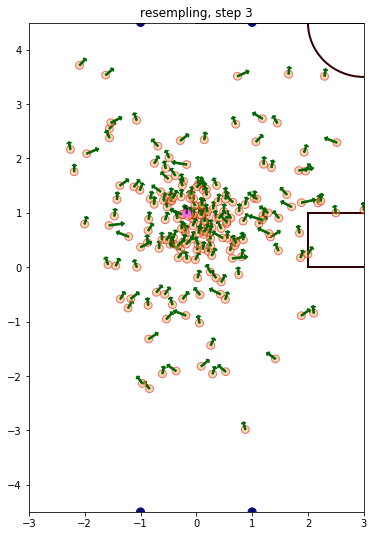

In [251]:
for log in vis_logs:
    visualization(vis_logs, log, factor = 7 )
    time.sleep(10)

<Figure size 432x288 with 0 Axes>

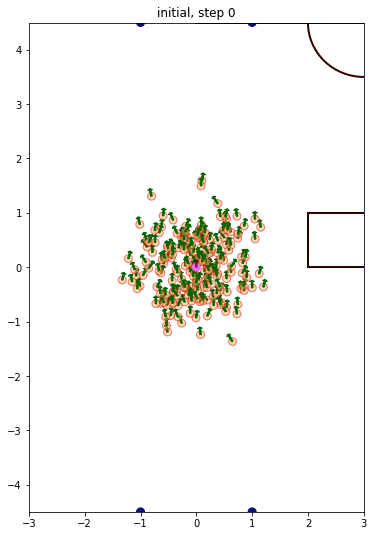

In [252]:
visualization(vis_logs, vis_logs[1], factor = 7 )